In [59]:





from Core.SearchSpace import SearchSpace
from Core.PRef import PRef
from Core.PS import PS
import numpy as np
from numba import njit


def boolean_array_to_bitwise(array: np.ndarray):
    return np.packbits(array)[0]

def convert_array_to_hot_encoding_bitwise(array: np.ndarray, search_space: SearchSpace):
    head = 1 << 63
    result = 0
    for value, cardinality in zip(array, search_space.cardinalities):
        result = result >> int(cardinality)
        if value >=0 :
            result = result | (head >> int(value))
    return np.uint64(result)

class FasterPRef:
    inverted_fsm: np.ndarray
    fitness_array: np.ndarray
    original_search_space: SearchSpace
    
    def __init__(self, inverted_fsm: np.ndarray,
                 fitness_array: np.ndarray,
                 original_search_space: SearchSpace):
        #full_solution_matrix.flags.writeable(False)
        self.inverted_fsm = inverted_fsm
        self.fitness_array = fitness_array
        self.original_search_space = original_search_space
        
    @classmethod
    def from_pRef(cls, pRef: PRef):
        
        new_fsm = np.array([np.bitwise_not(convert_array_to_hot_encoding_bitwise(row, pRef.search_space))
                            for row in pRef.full_solution_matrix], dtype=np.uint64)
        
        return cls(inverted_fsm=new_fsm, fitness_array=pRef.fitness_array, original_search_space= pRef.search_space)
    
    
    def get_matching_rows(self, ps: PS):
        ps_bitwise = convert_array_to_hot_encoding_bitwise(ps.values, self.original_search_space)
        # print(f"{type(ps_bitwise) = }, {ps_bitwise:b}")
        where_present = (self.inverted_fsm & ps_bitwise) == 0
        return where_present
        
    def fitnesses_of_observations(self, ps: PS):
        # print(f"Received {ps}")
        if ps.is_empty():
            return self.fitness_array
        
        # print(f"{where_present = }")
        return self.fitness_array[self.get_matching_rows(ps)]
        

In [130]:
import utils
from Core.get_pRef import get_pRef_from_metaheuristic
from BenchmarkProblems.RoyalRoad import RoyalRoad

problem = RoyalRoad(5)

old_pRef = get_pRef_from_metaheuristic(problem=problem,
                                   sample_size=10000,
                                   which_algorithm="GA",
                                   unique=True)
print(old_pRef)

PRef with 838 samples, mean = 8.40


In [131]:
new_pRef = FasterPRef.from_pRef(old_pRef)

pattern = PS.from_string("1"*5 + "*" * 15)





In [62]:
import pandas as pd
samples_per_category = 10000

categories = [0, 1, 2, 3, 4, 5, 10, 20]


def get_times_per_category_from_pref(pRef, pss):
    with utils.execution_timer() as timer:
        for ps in pss:
            pRef.fitnesses_of_observations(ps)
    return timer.runtime


data = []

for category in categories:
    print(f"gathering data for {category}")
    pss = [PS.random_with_fixed_size(search_space=problem.search_space, size = category) for _ in range(samples_per_category)]
    for_old = get_times_per_category_from_pref(old_pRef, pss)
    data.append({"category":category, "type": "old", "time": for_old})
    for_new = get_times_per_category_from_pref(new_pRef, pss)
    data.append({"category":category, "type": "new", "time": for_new})
    
    ratio = for_old / for_new
    print(f"For category {category}, the speedup is {ratio}x")



result_pd = pd.DataFrame(data)
    

gathering data for 0
For category 0, the speedup is 0.1960073816630875x
gathering data for 1
For category 1, the speedup is 2.967335015315148x
gathering data for 2
For category 2, the speedup is 3.828012875727694x
gathering data for 3
For category 3, the speedup is 4.956490674536317x
gathering data for 4
For category 4, the speedup is 5.7843193956666275x
gathering data for 5
For category 5, the speedup is 6.314465419832371x
gathering data for 10
For category 10, the speedup is 7.286535580463411x
gathering data for 20
For category 20, the speedup is 8.318086709778333x


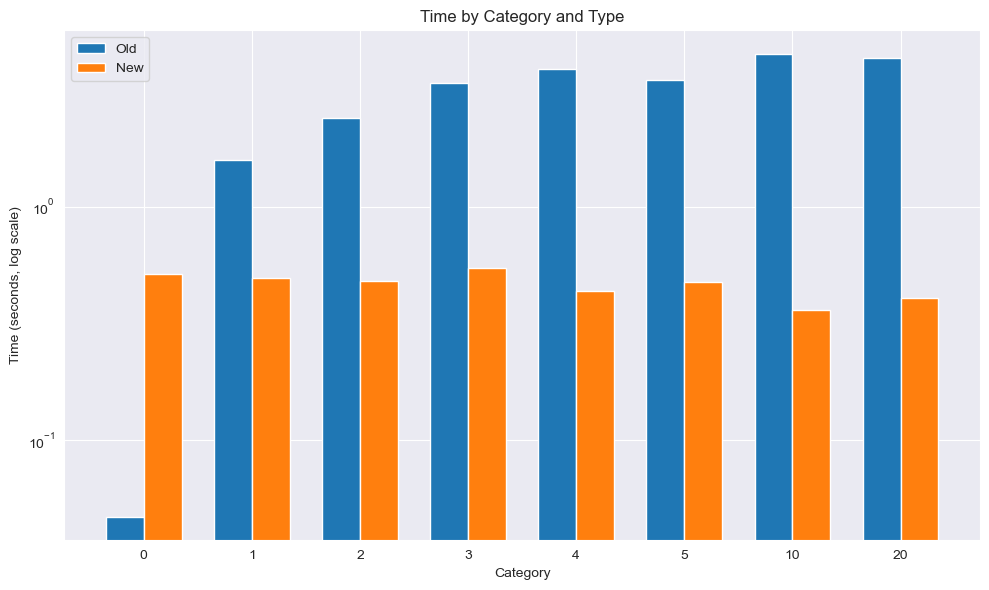

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example: assume your dataframe is called df
# df = pd.read_csv("your_data.csv")

# First, prepare the data: group by category and type, and calculate mean (or another statistic if you prefer)
df = result_pd
grouped = df.groupby(['category', 'type'])['time'].mean().unstack()

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set positions for groups
x = np.arange(len(grouped))
width = 0.35  # Width of the bars

# Plot 'old' and 'new' bars side by side
ax.bar(x - width/2, grouped['old'], width, label='Old')
ax.bar(x + width/2, grouped['new'], width, label='New')

# Log scale for y-axis
ax.set_yscale('log')

# Labels and titles
ax.set_xlabel('Category')
ax.set_ylabel('Time (seconds, log scale)')
ax.set_title('Time by Category and Type')
ax.set_xticks(x)
ax.set_xticklabels(grouped.index)
ax.legend()

plt.tight_layout()
plt.show()


In [81]:


def get_variance_from_pss(pss: list[PS], pRef: FasterPRef):
    pss_bitwise = np.array([convert_array_to_hot_encoding_bitwise(ps.values, pRef.original_search_space)
                            for ps in pss])
    
    def get_category_for_row(sol):
        result = 0
        for ps in pss_bitwise:
            result = result << 1
            result = result | ((sol & ps) == 0)
        return result
    
    sum_of_fitness = np.zeros(64, dtype=float)
    sum_of_squared_fitness = np.zeros(64, dtype=float)
    counts = np.zeros(64, dtype=int)
    
    for sol, fit in zip(pRef.inverted_fsm, pRef.fitness_array):
        category = get_category_for_row(sol)
        sum_of_fitness[category] += fit
        sum_of_squared_fitness[category] += fit**2
        counts[category] +=1
        
    
    
    valid_categories = (2 ** (len(pss)))
    if np.any(counts[:valid_categories] == 0):
        return 10000
    
    expected_square = sum_of_squared_fitness[:valid_categories] / counts[:valid_categories]
    expected_normal = sum_of_fitness[:valid_categories] / counts[:valid_categories]
    
    
    return np.sum(expected_square - expected_normal) / valid_categories

pss= problem.get_targets()

print(get_variance_from_pss(pss, new_pRef))

110.0


In [132]:
import heapq
from Core.PS import STAR
import random
quantity_of_pss = 1
ss = problem.search_space

genome_size = ss.amount_of_parameters * quantity_of_pss

def generate_random_pss():
    result = np.zeros(genome_size, dtype=int) - 1
    while random.random() < 0.14:
        result[random.randrange(genome_size)] = random.randrange(2)
    return result


mutation_rate = 0.05
def mutate_pss(original):
    result = original.copy()
    while random.random() < 0.14:
        result[random.randrange(genome_size)] = random.randrange(3)-1
    return result


def crossover(mother, father):
    crossover_region = np.random.random(genome_size) < 0.05
    daughter = mother.copy()
    son = father.copy()
    
    daughter[crossover_region] = father[crossover_region]
    son[crossover_region] = mother[crossover_region]
    return daughter, son

calls = [0]
def fitness_function(pss):
    calls[0] +=1
    print(f"ff calls {calls}")
    
    values = pss.reshape((quantity_of_pss, -1))
    actual_pss = [PS(v) for v in values]
    return get_variance_from_pss(actual_pss, new_pRef)

pop_size = 100
def get_initial_population():
    return [generate_random_pss() for _ in range(pop_size)]


def new_population(old_population):
    print("evaluating..")
    winners = heapq.nsmallest(n = int(pop_size*0.5), key=fitness_function, iterable=old_population)
    
    print("Generating new")
    random_children = []
    while (len(random_children)) + len(winners) < pop_size:
        father, mother = random.choice(winners), random.choice(winners)
        daughter, son = crossover(mutate_pss(father), mutate_pss(mother))
        random_children.append(daughter)
        random_children.append(son)
    
    return (winners + random_children)[:pop_size]



def inline_GA(budget):
    used_evals = 0
    
    pop = get_initial_population()
    while used_evals < budget:
        print(int((used_evals / budget)*100))
        pop = new_population(pop)
        used_evals += pop_size
    
    return min(pop, key=fitness_function)


    


In [102]:
result_of_fa = inline_GA(1000)

0
evaluating..
ff calls [1]
ff calls [2]
ff calls [3]
ff calls [4]
ff calls [5]
ff calls [6]
ff calls [7]
ff calls [8]
ff calls [9]
ff calls [10]
ff calls [11]
ff calls [12]
ff calls [13]
ff calls [14]
ff calls [15]
ff calls [16]
ff calls [17]
ff calls [18]
ff calls [19]
ff calls [20]
ff calls [21]
ff calls [22]
ff calls [23]
ff calls [24]
ff calls [25]
ff calls [26]
ff calls [27]
ff calls [28]
ff calls [29]
ff calls [30]
ff calls [31]
ff calls [32]
ff calls [33]
ff calls [34]
ff calls [35]
ff calls [36]
ff calls [37]
ff calls [38]
ff calls [39]
ff calls [40]
ff calls [41]
ff calls [42]
ff calls [43]
ff calls [44]
ff calls [45]
ff calls [46]
ff calls [47]
ff calls [48]
ff calls [49]
ff calls [50]
ff calls [51]
ff calls [52]
ff calls [53]
ff calls [54]
ff calls [55]
ff calls [56]
ff calls [57]
ff calls [58]
ff calls [59]
ff calls [60]
ff calls [61]
ff calls [62]
ff calls [63]
ff calls [64]
ff calls [65]
ff calls [66]
ff calls [67]
ff calls [68]
ff calls [69]
ff calls [70]
ff calls [71]


In [160]:


from Core.PSMetric.Linkage.TraditionalPerturbationLinkage import TraditionalPerturbationLinkage
from Core.PSMetric.Linkage.ValueSpecificMutualInformation import FasterSolutionSpecificMutualInformation
from Core.PSMetric.Simplicity import Simplicity
from Core.PSMetric.FitnessQuality.MeanFitness import MeanFitness

pattern = PS.from_string("1"*5 + "*" * 15)
to_explain = old_pRef.get_best_solution()

def mf(ps):
    return np.var(new_pRef.fitnesses_of_observations(ps))

simpl_metric = Simplicity()
def simplicity(ps):
    return -simpl_metric.get_single_score(ps)

atomicity_metric = TraditionalPerturbationLinkage(problem)
atomicity_metric.set_solution(to_explain)


def atomicity(ps):
    return -atomicity_metric.get_atomicity(ps)


def dependence(ps):
    return -atomicity_metric.get_dependence(ps)

print(mf(pattern), simplicity(pattern), atomicity(pattern))

8.413553719008263 -15.0 -2.4


In [1]:
from SimplifiedSystem.ps_search_utils import run_pymoo_algorithm_with_checks
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from SimplifiedSystem.Operators.Sampling import LocalPSGeometricSampling
from SimplifiedSystem.LocalPSSearchTask import LocalPSSearchTask

objectives = [atomicity, dependence]




ga_problem = LocalPSSearchTask(solution_to_explain=to_explain,
                                objectives=objectives,
                                unexplained_mask=None,
                                proportion_unexplained_that_needs_used=0.01,
                                proportion_used_that_should_be_unexplained=0.01)

# if there are no operators given, we have these defaults
sampling_operator = LocalPSGeometricSampling()
crossover_operator = SimulatedBinaryCrossover(prob=0.3)
mutation_operator = BitflipMutation(prob=1 / ga_problem.n_var)

# the next line of code is a bit odd, but it works! It uses a GA if there is one objective
algorithm = (GA if len(objectives) < 2 else NSGA2)(pop_size=population_size,
                                                   sampling=sampling_operator,
                                                   crossover=crossover_operator,
                                                   mutation=mutation_operator,
                                                   eliminate_duplicates=True)

pss = run_pymoo_algorithm_with_checks(pymoo_problem=ga_problem,
                                      algorithm=algorithm,
                                      reattempts_when_fail=5,
                                      ps_budget = 10000,
                                      verbose=True)

NameError: name 'atomicity' is not defined

In [123]:
pss.sort(key=lambda x: x.metric_scores[2])

for ps in pss:
    print(ps)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1][0.000, -0.001, 0.000, ]
[1 1 1 1 1 1 1 1 1 1 * 1 1 1 1 1 1 1 1 1][0.423, -0.001, 0.000, ]
[1 1 1 1 1 1 1 1 1 * * 1 1 1 1 1 1 1 1 1][0.878, -0.001, 0.000, ]
[1 1 1 1 1 1 1 1 1 1 1 * 1 1 1 1 1 1 1 1][0.420, -0.001, 0.000, ]
[* 1 1 1 1 1 1 1 1 * * 1 1 1 1 1 1 1 1 1][1.337, -0.001, 0.000, ]
[1 1 1 1 1 1 1 1 1 1 * * 1 1 1 1 1 1 1 1][0.804, -0.001, 0.000, ]
[1 1 1 1 1 1 1 1 * * * 1 1 1 1 1 1 1 1 1][1.265, -0.001, 0.000, ]
[1 1 1 1 1 1 1 1 1 * * * 1 1 1 1 1 1 1 1][1.219, -0.001, 0.001, ]
[1 1 1 1 1 1 1 1 * * * * 1 1 1 1 1 1 1 1][1.576, -0.001, 0.001, ]
[1 1 1 1 1 1 1 1 * 1 * * 1 1 1 1 1 1 1 1][1.189, -0.001, 0.001, ]
[1 1 1 1 1 * 1 1 1 1 1 1 1 1 1 1 1 1 1 1][0.414, -0.001, 0.001, ]
[* 1 1 1 1 1 1 1 * * * 1 1 1 1 1 1 1 1 1][1.706, -0.001, 0.001, ]
[* 1 1 1 1 1 1 1 1 * * * 1 1 1 1 1 1 1 1][1.666, -0.001, 0.001, ]
[* * 1 * 1 1 1 1 1 * * 1 1 1 1 1 1 1 1 1][2.145, -0.002, 0.001, ]
[* 1 1 1 1 1 1 1 * * * * 1 1 1 1 1 1 1 1][2.005, -0.002, 0.001, ]
[* * 1 * 1

In [124]:
atomicity_metric.linkage_table

array([[ 3.32542243e-04,  9.07389849e-04,  8.09615273e-04,
         7.56463981e-04,  2.25306379e-04,  3.38443901e-04,
         2.28719777e-04,  3.47561094e-04, -1.52330030e-05,
         1.34868467e-04,  9.01155048e-06,  1.42706496e-04,
         2.86293222e-04,  3.20331878e-04,  3.21795176e-04,
         2.18099458e-04,  5.29314905e-04,  2.72227594e-04,
         1.98474007e-04,  2.86912618e-04],
       [ 9.07389849e-04,  4.99074995e-04,  1.10044482e-03,
         1.26641303e-03,  2.33694403e-04,  3.55385504e-04,
         4.26220546e-04,  2.91618602e-04,  1.36760056e-04,
         1.45505891e-04,  4.38623586e-05,  2.30478870e-04,
         8.36838710e-04,  8.13218335e-04,  5.37504868e-04,
         6.82035183e-04,  4.04794536e-04,  2.86188365e-04,
         2.36842824e-04,  5.47228172e-04],
       [ 8.09615273e-04,  1.10044482e-03,  6.70772852e-04,
         1.26736389e-03,  1.47422828e-04,  2.95732253e-04,
         2.91368371e-04,  2.35960493e-04,  6.99730361e-04,
         2.13153710e-04,  2.1

In [125]:
from matplotlib import pyplot as plt
from typing import Optional
import seaborn as sns

import numpy as np


def show_matrix_with_colours(table: np.ndarray,
                             name: str = "",
                             row_labels=None,
                             col_labels=None,
                             save_to: Optional[str] = None,
                             fig_size: Optional[tuple[float]] = (10, 10)):
    if row_labels is None:
        row_labels = [str(i) for i in range(table.shape[0])]
    if col_labels is None:
        col_labels = [str(j) for j in range(table.shape[1])]

    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(
        table,
        cmap="viridis",
        center=0,
        linewidths=0.5,
        xticklabels=col_labels,
        yticklabels=row_labels,
        cbar=True
    )
    ax.set_title(name)
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()

    if save_to:
        plt.savefig(save_to)
    else:
        plt.show()

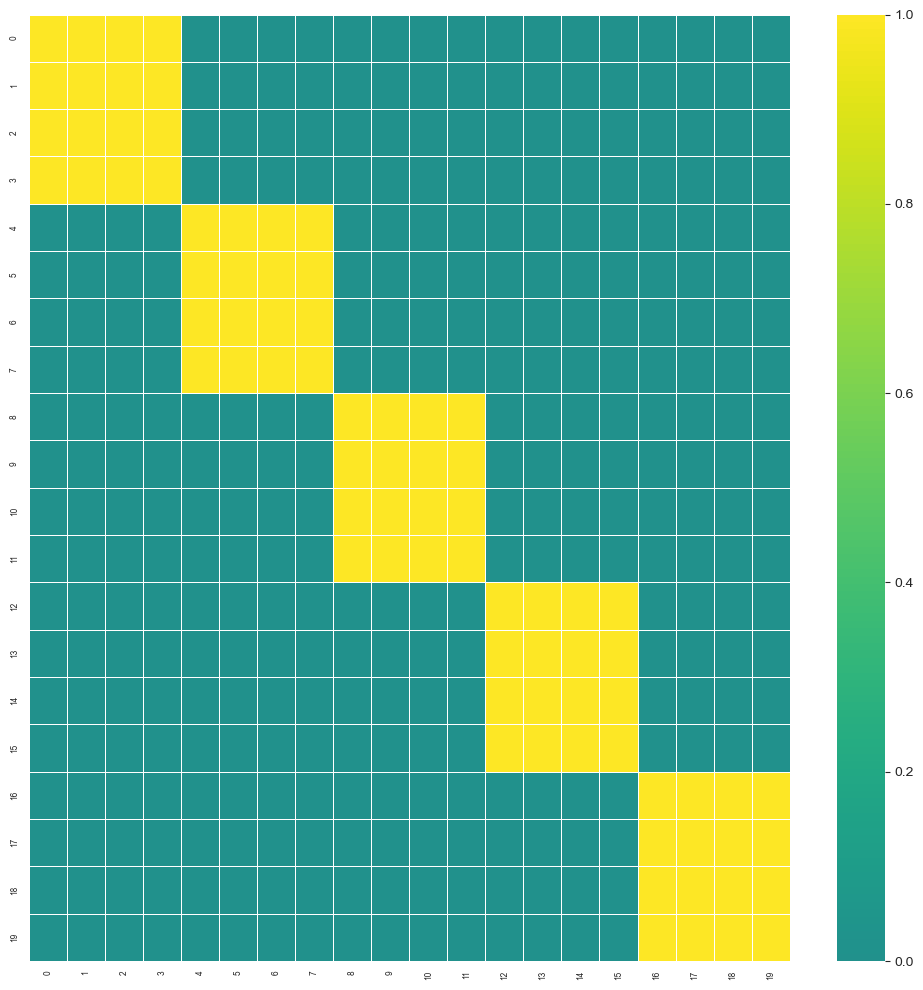

In [145]:
show_matrix_with_colours(linkage_table)

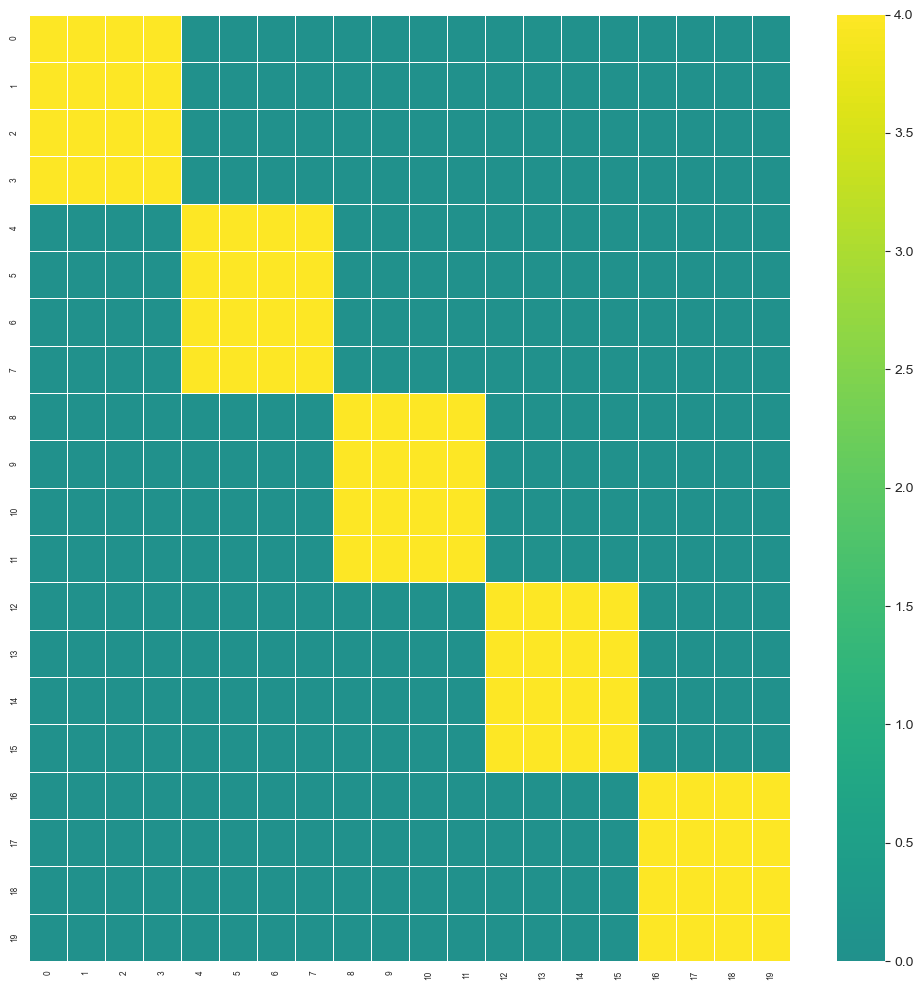